## Tsfresh data preparation


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as imb_pipe


In [4]:
df = pd.read_csv('data/data_processed/client_data.csv')

In [5]:
merged_df = df.copy()

In [6]:
#drop the columns
merged_df.drop("creation_date", axis=1, inplace=True)

In [7]:
# Convert invoice_date to datetime
merged_df

,disrict,client_catg,region,target,1transactions_count,consumption_level_1_mean,consumption_level_2_mean,consumption_level_3_mean,consumption_level_4_mean
0,60,11,101,0.0,35,352.400000,10.571429,0.000000,0.000000
1,69,11,107,0.0,37,557.540541,0.000000,0.000000,0.000000
2,62,11,301,0.0,18,798.611111,37.888889,0.000000,0.000000
3,69,11,105,0.0,20,1.200000,0.000000,0.000000,0.000000
4,62,11,303,0.0,14,663.714286,104.857143,117.357143,36.714286
...,...,...,...,...,...,...,...,...,...
135488,62,11,304,0.0,71,1.957746,0.000000,0.000000,0.000000
135489,63,11,311,0.0,41,185.853659,0.756098,0.000000,0.000000
135490,63,11,311,0.0,36,273.083333,0.000000,0.000000,0.000000
135491,60,11,101,0.0,2,300.000000,70.500000,0.000000,0.000000


In [8]:
#defining the target variable and features
target = ['target']
num_features = ['client_id',
                '1transactions_count',
                'consumption_level_1_mean',
                'consumption_level_2_mean',
                'consumption_level_3_mean',
                'consumption_level_4_mean']
cat_features = [col for col in merged_df.columns if col not in num_features and col not in target]

In [9]:
#preprocessing categorical features
cat_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('one_hot_encoding', OneHotEncoder())
])

In [10]:
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, cat_features),
    #('num', num_pipeline, num_features)
], remainder='passthrough')

In [26]:
df = merged_df.copy()
X = df.drop(columns=["target"], axis=1)  
y = df["target"]

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [27]:
# unbalanced dataset?
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

In [38]:
model_stage1 = XGBClassifier()
                            # n_estimators=500, 
                            #  random_state=42,
                            #  max_depth=5,        # avoids overfitting
                            # learning_rate=0.05, # Slow learning
                            # subsample=0.8,      # randomness
                            # colsample_bytree=0.8, 
                            # scale_pos_weight=scale_pos_weight,  # Adjust based on fraud ratio
                            # eval_metric="aucpr") 

In [39]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model_stage1) 
])

In [40]:
model_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('one_hot_encoding',
                                                                   OneHotEncoder())]),
                                                  ['disrict', 'client_catg',
                                                   'region'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_byle...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [41]:
# Train the model
model_pipeline.fit(X_train, y_train)

e:\Work\AI+Datascience\SunSafe\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('one_hot_encoding',
                                                                   OneHotEncoder())]),
                                                  ['disrict', 'client_catg',
                                                   'region'])])),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_byle...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [42]:
ros = RandomOverSampler(random_state=10, sampling_strategy='auto') 

# pipeline
ros_pipeline = imb_pipe(ros, model_pipeline)



In [43]:
ros_pipeline.fit(X_train, y_train)

e:\Work\AI+Datascience\SunSafe\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('randomoversampler', RandomOverSampler(random_state=10)),
                ('pipeline',
                 Pipeline(steps=[('preprocessor',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('cat',
                                                                   Pipeline(steps=[('simple_imputer',
                                                                                    SimpleImputer(fill_value='missing',
                                                                                                  strategy='most_frequent')),
                                                                                   ('one_hot_encoding',
                                                                                    OneHotEncoder())]),
                                                                   ['disrict',
                                                                    'client_catg',
                                                                    'region'])...
                                                grow_policy=None,
                                                importance_type=None,
                                                interaction_constraints=None,
                                                learning_rate=None,
                                                max_bin=None,
                                                max_cat_threshold=None,
                                                max_cat_to_onehot=None,
                                                max_delta_step=None,
                                                max_depth=None, max_leaves=None,
                                                min_child_weight=None,
                                                missing=nan,
                                                monotone_constraints=None,
                                                multi_strategy=None,
                                                n_estimators=None, n_jobs=None,
                                                num_parallel_tree=None,
                                                random_state=None, ...))]))])

In [44]:
ros_pipeline.score(X_test, y_test)

0.7345994882897068

In [33]:
# Define the hyperparameter search space
param_distributions = {
    'pipeline__model__n_estimators': np.arange(50, 500, 50),
    'pipeline__model__max_depth': np.arange(3, 10),
    'pipeline__model__learning_rate': np.logspace(-3, 0, 10),
    'pipeline__model__subsample': np.linspace(0.5, 1, 5),
    'pipeline__model__scale_pos_weight': [0]
}

# Define RandomizedSearchCV
random_search = RandomizedSearchCV(
    ros_pipeline, param_distributions,
    n_iter=20,  # Number of random samples
    scoring='roc_auc',  # Optimize for F1-score
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all CPUs
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

e:\Work\AI+Datascience\SunSafe\.venv\Lib\site-packages\sklearn\model_selection\_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan]
  warnings.warn(
e:\Work\AI+Datascience\SunSafe\.venv\Lib\site-packages\sklearn\compose\_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('randomoversampler',
                                              RandomOverSampler(random_state=10)),
                                             ('pipeline',
                                              Pipeline(steps=[('preprocessor',
                                                               ColumnTransformer(remainder='passthrough',
                                                                                 transformers=[('cat',
                                                                                                Pipeline(steps=[('simple_imputer',
                                                                                                                 SimpleImputer(fill_value='missing',
                                                                                                                               strategy='most_frequent')),
                                                                                                                ('one_hot_encoding',
                                                                                                                 OneHotEncoder())]),
                                                                                                [...
                   param_distributions={'pipeline__model__learning_rate': array([0.001     , 0.00215443, 0.00464159, 0.01      , 0.02154435,
       0.04641589, 0.1       , 0.21544347, 0.46415888, 1.        ]),
                                        'pipeline__model__max_depth': array([3, 4, 5, 6, 7, 8, 9]),
                                        'pipeline__model__n_estimators': array([ 50, 100, 150, 200, 250, 300, 350, 400, 450]),
                                        'pipeline__model__scale_pos_weight': [0],
                                        'pipeline__model__subsample': array([0.5  , 0.625, 0.75 , 0.875, 1.   ])},
                   random_state=42, scoring='roc_auc')

In [34]:
#extracting the best model
best_model = random_search.best_estimator_

In [35]:
#classification report of best model
y_pred = best_model.predict(X_test) 
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     38378
         1.0       0.00      0.00      0.00      2270

    accuracy                           0.94     40648
   macro avg       0.47      0.50      0.49     40648
weighted avg       0.89      0.94      0.92     40648



e:\Work\AI+Datascience\SunSafe\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Work\AI+Datascience\SunSafe\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\Work\AI+Datascience\SunSafe\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
#confusion matrix of best model
confusion_matrix(y_test, y_pred)

array([[38378,     0],
       [ 2270,     0]], dtype=int64)

In [37]:
# Make predictions
y_pred = model_pipeline.predict(X_test)

# Output predictions
print("Predictions:", y_pred)

Predictions: [0 0 0 ... 0 0 0]


In [25]:
# confusion matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[38321    57]
 [ 2248    22]]
              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     38378
         1.0       0.28      0.01      0.02      2270

    accuracy                           0.94     40648
   macro avg       0.61      0.50      0.49     40648
weighted avg       0.91      0.94      0.92     40648



In [65]:
# # probabilities for fraud
fraud_probs_stage1 = model_pipeline.predict_proba(X_test)[:, 1]  

# Fraud probabilities for second stage model > 50%
# 1st stage: optimize recall, 2nd stage optimize precision
suspicious_cases = X_test[fraud_probs_stage1 > 0.30] # only use propabilities larger 30% for2nd stage model

# not needed 
y_suspicious = y_test[fraud_probs_stage1 > 0.30] # snot used

In [ ]:
# decision tree for second stage
dt_model_stage2 = LogisticRegression(C=0.1, 
    penalty='l1', 
    solver='liblinear', 
    class_weight='balanced', 
    max_iter=500)
dt_model_stage2.fit(suspicious_cases, y_suspicious)

fraud_probs_stage2 = dt_model_stage2.predict_proba(suspicious_cases)[:, 1]

# categorize risk
def risk_category(prob):
    if prob > 0.7:
        return "High Risk"
    elif prob > 0.4:
        return "Medium Risk"
    else:
        return "Low Risk"

suspicious_cases_output = suspicious_cases.copy()
suspicious_cases_output["Risk Level"] = [risk_category(p) for p in fraud_probs_stage2]


In [67]:
high_risk_cases = suspicious_cases_output#[suspicious_cases_output["Risk Level"] == "High Risk"]
high_risk_cases.head()

,disrict,client_catg,region,1transactions_count,consumption_level_1_mean,consumption_level_2_mean,consumption_level_3_mean,consumption_level_4_mean,Risk Level
134491,60,11,101,26,676.000000,117.076923,8.653846,0.0,Low Risk
92503,63,11,311,82,397.329268,10.439024,0.000000,0.0,Medium Risk
5677,69,11,103,32,443.281250,14.312500,0.000000,0.0,Medium Risk
87512,60,11,101,22,389.727273,4.863636,0.000000,0.0,Low Risk
12682,60,11,101,34,608.647059,226.000000,21.470588,0.0,Low Risk


<Axes: xlabel='Risk Level'>

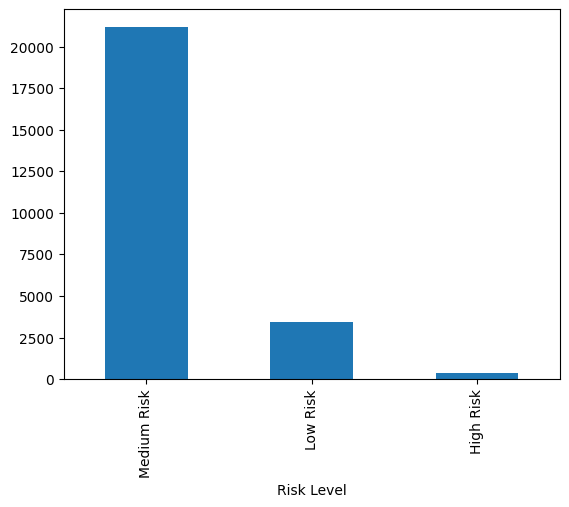

In [ ]:
# plot high risk for each risk level barplot count
high_risk_cases["Risk Level"].value_counts().plot(kind='bar')